# Wavefront propagation using the SimEx Calculator "WavePropagator"

In this notebook, we will demonstrate how to propagate a simple Gaussian wavefront between two planes through vacuum. This is the simplest case of coherent wavefront propagation.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
# Import all SimEx modules
from SimEx.Calculators.WavePropagator import WavePropagator
from SimEx.Calculators.GaussianPhotonSource import GaussianPhotonSource
from SimEx.Parameters.WavePropagatorParameters import WavePropagatorParameters
from SimEx.Parameters.GaussWavefrontParameters import GaussWavefrontParameters

from SimEx.Utilities.Units import electronvolt, meter, joule, radian
import numpy

initializing ocelot...


### Setup the initial wavefront
We first create a wavefront with a Gaussian intensity distribution. To this end, we use the `GaussianPhotonSource` Calculator and it's corresponding parameter class, the `GaussWavefrontParameters`. Looking up the documentation of these two classes gives us the information needed to create the instances:

In [4]:
GaussWavefrontParameters?

In [5]:
GaussianPhotonSource?

We first describe the wavefront parameters which will then be used to create the wavefront itself:

In [4]:
wavefront_parameters = GaussWavefrontParameters(photon_energy=8.0e3*electronvolt,
                                                photon_energy_relative_bandwidth=1e-3,
                                                beam_diameter_fwhm=1.0e-4*meter,
                                                pulse_energy=2.0e-6*joule,
                                                number_of_transverse_grid_points=400,
                                                number_of_time_slices=12,
                                                )

Now, we use the just created `wavefront_parameters` to initialize the Photon Source.

In [5]:
photon_source = GaussianPhotonSource(wavefront_parameters, input_path="/dev/null", output_path="initial_wavefront.h5")

Let's calculate the initial wavefront and visualize it:

In [6]:
photon_source.backengine()

beam waist radius from divergence angle = 8.493e-05
beam waist radius from fwhm = 8.493e-05


We can retrieve the wavefront data from the calculator:

In [7]:
wavefront = photon_source.data

Let's visualize the wavefront using the WPG utilities.

In [8]:
from wpg import wpg_uti_wf as wpg_utils

First plot the intensity distribution

R-space
(400,) (400,)
FWHM in x = 1.019e-04 m.
FWHM in y = 1.019e-04 m.


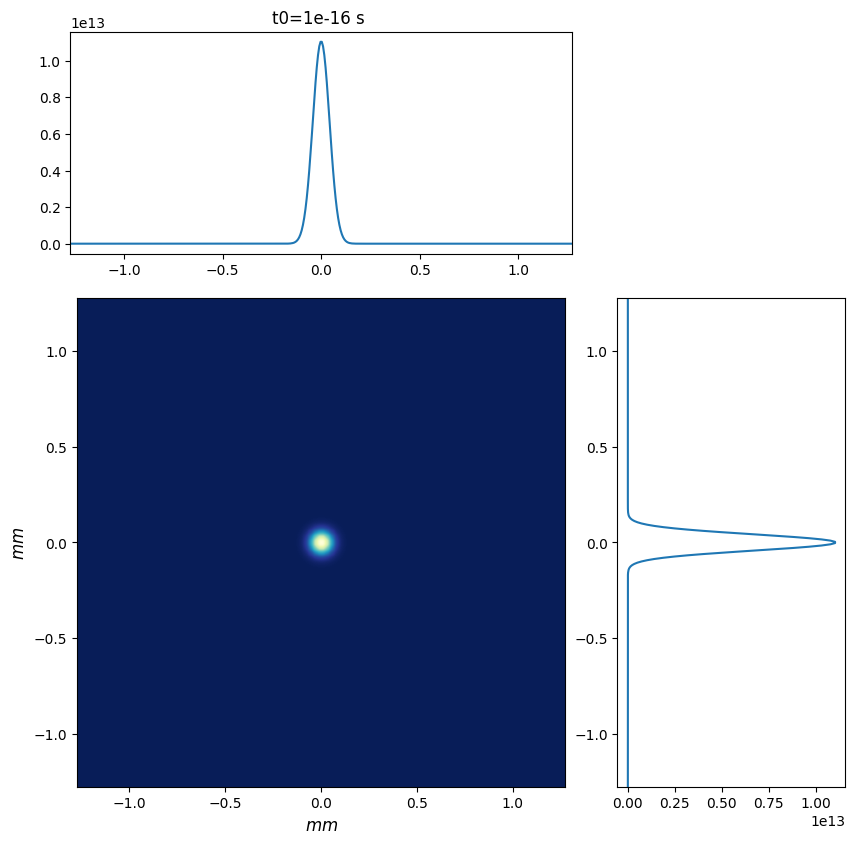

In [9]:
wpg_utils.plot_intensity_map(wavefront)

## Plot intensity distribution in q-space

Q-space
{'fwhm_x': 6.657123479604694e-07, 'fwhm_y': 6.657123479604694e-07}
Q-space
(400,) (400,)


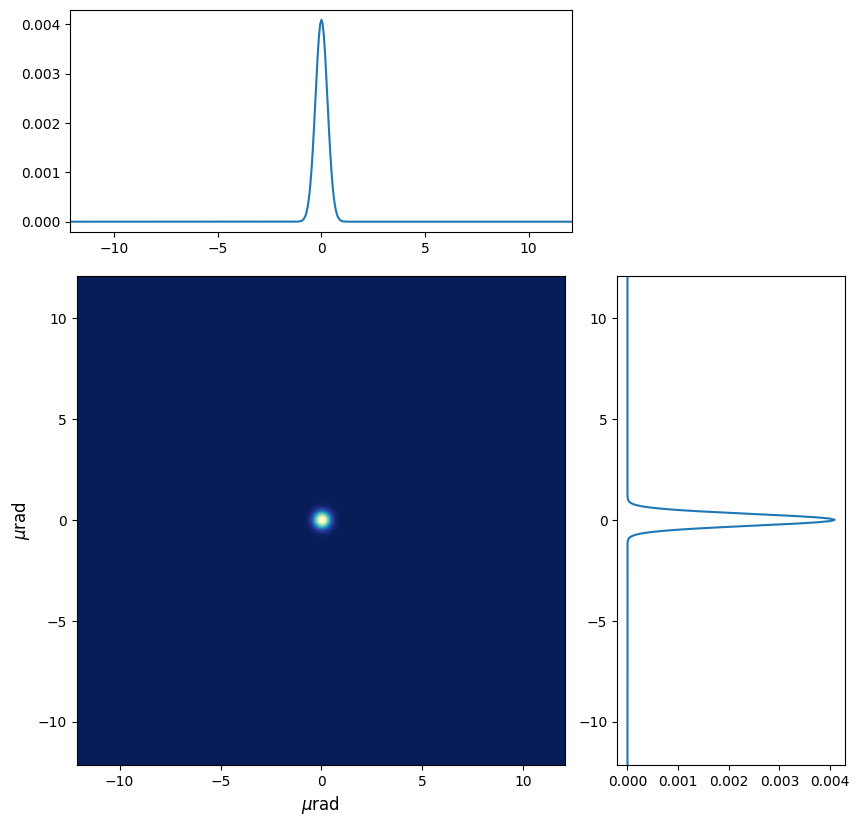

In [10]:
wpg_utils.plot_intensity_qmap(wavefront)

Plot the power as a function of time integrated over the transverse dimensions

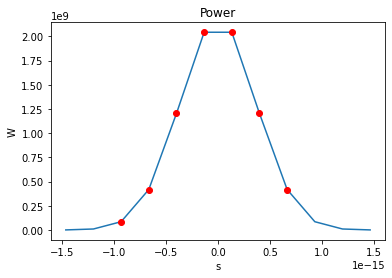

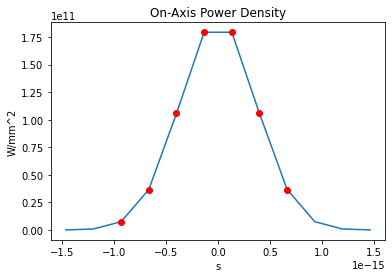

number of meaningful slices: 7
Pulse energy 2e-06 J


1059337216.0

In [11]:

wpg_utils.integral_intensity(wavefront)

Plot the power spectrum

In [12]:
import wpg

Check the sampling quality

In [13]:
print(wpg_utils.check_sampling(wavefront))

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|1.019e-04|6.386e-06|2.548e-03|0.000e+00|0.000e+00|4.470e-05|6.386e-05|
|Vertical  |1.019e-04|6.386e-06|2.548e-03|0.000e+00|0.000e+00|4.470e-05|6.386e-05|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI !> 3* FWHM(x) -> Increase ROI width (x).
Horizontal ROI !> 3* FWHM(y) -> Increase ROI height (y).
Focus sampling: FWHM > 10*px

END OF REPORT


Ok, we're happy with our initial wavefront and will now proceed to setup the beamline. Our beamline will consist just of a stretch of vacuum over 10 m distance.

## Estimate the beam size after 100 m propagation through empty space
Before we launch the numerical propagation machinery, let's estimate the beam size to be expected after propagating through 10 m of vacuum. 

The beam waist size (rms width of the E-field distribution, or distance from beam axis where intensity drops to $1/e^2$ of its on-axis value) is given by the expression

$ w(z) = w_0 \sqrt{1 + \left(\frac{z}{R}\right)^2}$, with the Rayleigh length $R = \frac{\pi w_0^2}{\lambda}$, $\lambda$ is the central wavelength of the laser (ca,. 0.15 nm at 8 keV.)

Our Gaussian source distribution has a FWHM of $10^{-4} m$. The FWHM and the beam waist radius as defined above are related to each other through $\mathrm{FWHM}(z) = \sqrt{2 \ln 2} w(z) \simeq 1.177 w(z)$


Beam waist at z=0: $w_0 = 100\,\mathrm{\mu m} / 1.177 \simeq 84.9\,\mathrm{\mu m}$.  
The Rayleigh length for our Gaussian beam is $R = \frac{\pi w_0^2}{0.15 \mathrm{nm}} \simeq 151\,\mathrm{m}$.

At $z=100\,\mathrm{m}$, we therefore expect a FWHM of $100\,\mu\mathrm{m}\cdot\sqrt{1.+\left(100/151\right)^2} \simeq 119.9 \mu\mathrm{m}$.

For numerical reasons, we have to set the radius of curvature to a finite value. Here we choose to set it to a value corresponding approximately to a distance of 1 m from the source position, $z = 1\,\mathrm{m}$.

In [14]:
wavefront.params.Rx = wavefront.params.Ry = 150**2

## Setup the beamline

In [21]:
from wpg import Beamline, optical_elements, srwlib


In [16]:
beamline = Beamline()

In [17]:
free_space = optical_elements.Drift(_L=100, _treat=1)

In [18]:
free_space_propagation_parameters = optical_elements.Use_PP(semi_analytical_treatment=1)

In [19]:
beamline.append(free_space, free_space_propagation_parameters)

In [20]:
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 'f')
beamline.propagate(wavefront)
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 't')

R-space
(400,) (400,)
FWHM in x = 1.152e-04 m.
FWHM in y = 1.152e-04 m.


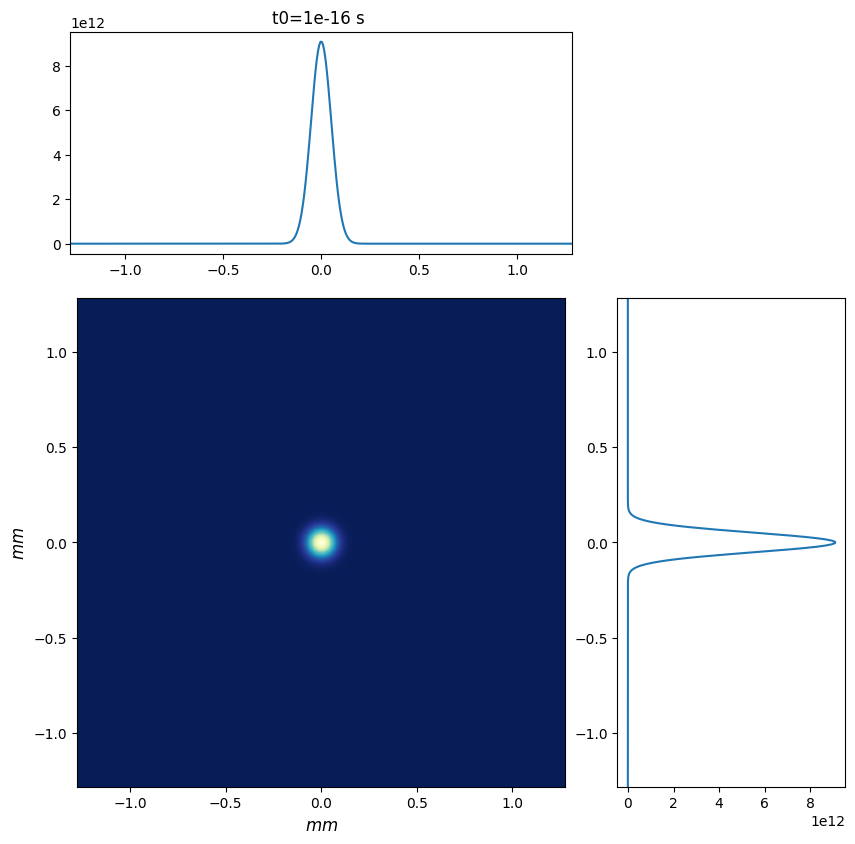

In [22]:
wpg_utils.plot_intensity_map(wavefront)

The result is $\mathrm{FWHM} = 115.2\,\mathrm{\mu m}$ at $z=100\,\mathrm{m}$. Considering that the FWHM is measured by counting pixels in the intensity profile, this is in rather good agreement with the analytical calculation above.